In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle

In [3]:
def compute_phonons(estimations, cov_matrix, step=100):
    sampled_cov_matrix = [el[2:,2:] for el in kalman.error_covariance_apriori[::step]]
    N = len(sampled_cov_matrix)
    phonons = np.zeros((N-1))
    for i in range(1, N):
        averaged = estimations[(i-1)*step:i*step, 2:].mean(axis=0)
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons[i-1] = np.trace(second_moments)/4-0.5
    return phonons

In [12]:
T = 293
rho = 2200
index_refraction = 1.4440
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
tweezer_waist = 0.6e-6
eta_detection = 1
delta_t = 3e-10
control_step = int(30*1e-9/delta_t) # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

cavity_waist = 100e-6
cavity_length = 50e-3
coupling = 6.68e-42

detuning_ratio = 0.25 #defined with respect to the particle's frequency
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 2.5

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection,\
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,\
                                     T = T, rho = rho, index_refraction = index_refraction)
coupling = (1/(4*np.pi))*(ba_force**2)

g_0 = 0.19*omega
g_fb = 5*omega

N = np.linspace(1,50,20)

In [13]:
SNRs = []
for number in tqdm(N):
    
    period = 2 * np.pi / omega
    t = np.arange(0, 5 * period, delta_t)
    
    env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*g_0,
    coupling,
    radius=radius,
    rho=rho,
    eta_detection=eta_detection,
    T=T
    )
    if std_detection < 1:
        std_detection = std_detection/env.zp_x
    
    pulse_amplitude = np.sqrt(number)
    pulse_center = 5000+int(3*t.shape[0]/4)
    round_trip_time = 2*cavity_length/ct.c
    #https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
    trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
    pulse_width = trips*round_trip_time/delta_t
    alpha_in = []
    for i in range(t.shape[0]):
        alpha = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
            np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
        )
        alpha_in.append(alpha)
    
    variance_process = env.thermal_force_std**2 + env.backaction_std**2
    Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
    )*control_step*delta_t/2
    R = np.array([[np.power(std_detection, 2)]])
    
    Ad = scipy.linalg.expm(env.A *control_step*delta_t)
    Bd = env.B * delta_t * control_step
    cost_states = np.array([[omega/2, 0, 0, 0],
                            [0, omega/2, 0, 0],
                            [0, 0, omega/2, 0],
                            [0, 0, 0, omega/2]
                           ])
    (G_lqr, S, E) = lqr(env.A, env.B, cost_states, omega/(g_fb**2))
    X, L, G = dare(Ad, Bd, cost_states, omega/(g_fb**2))
    G_lqr, G
    
    x0 = 0
    P0 = np.matrix([[0,0,0,0],
                   [0,0,0,0],
                   [0,0,1,0],
                   [0,0,0,1]])
    estimation = np.matrix([[0], [0], [x0], [0]])
    states = np.array([[0], [0], [x0], [0.0]])
    G, omega, Ad, env.B*delta_t*control_step
    new_states = np.zeros((t.shape[0], 4))
    measured_states = np.zeros((t.shape[0]))
    estimated_states = np.zeros((t.shape[0], 4))
    estimated_states[0, :] = estimation.reshape((4))
    estimation = estimation.reshape((4, 1))
    control = np.array([[0]])
    controls = []
    kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
    for i in range(t.shape[0]):
        new_states[i, :] = states[:, 0]
        if not i % control_step:
            measured_states[i] = states[2, 0] + std_detection * np.random.normal()
            kalman.propagate_dynamics(control)
            kalman.compute_aposteriori(measured_states[i])
            estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((4))
            estimation = estimated_states[i, :].reshape((4, 1))
            control = -np.matmul(G, estimation)
        else:
            measured_states[i] = measured_states[i-1]
            estimated_states[i, :] = estimated_states[i-1,:]

        controls.append(float(control))
        states = env.step(states, alpha_in=alpha_in[i], control=control, delta_t=delta_t)
    
    '''
    step = 50
    start = 1
    phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
    left = int((pulse_center-40*pulse_width)/(control_step*step))
    right = int((pulse_center+15*pulse_width)/(control_step*step))
    t_sample = t[::control_step][::step][left:right]
    signal_sample = phonons[left:right]
    if len(t_sample) > len(signal_sample):
        t_sample = t_sample[1:]
    max_idx = np.where(signal_sample == max(signal_sample))[0][0]
    signal_crop = np.append(signal_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                              signal_sample[max_idx + int(8*pulse_width/(control_step*step)):])
    t_crop = np.append(t_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                              t_sample[max_idx + int(8*pulse_width/(control_step*step)):])
    
    SNR = max(signal_sample)/(max(signal_crop) + np.std(signal_crop))'''
    
    step = 5
    phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
    centre = int(pulse_width/(control_step*step))
    signal_right = phonons[centre:]
    signal_left = phonons[:centre]
    SNR = np.std(signal_right)/np.std(signal_left)
    
    SNRs.append(SNR)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\jorge\AppData\Local\Temp\ipykernel_20492\2075393205.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i, :] = states[:, 0]
C:\Users\jorge\AppData\Local\Temp\ipykernel_20492\2075393205.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[2, 0] + std_detection * np.random.normal()
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:39<00:00, 20.00s/it]


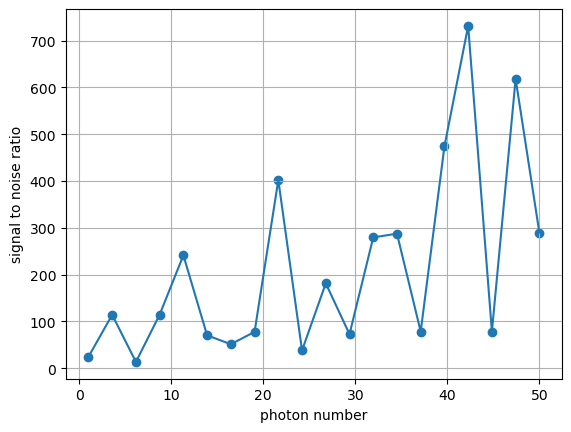

In [14]:
fig,axis = plt.subplots()
plt.plot(N[:],SNRs)
plt.scatter(N[:],SNRs)
plt.grid()
plt.xlabel('photon number')
plt.ylabel('signal to noise ratio')
plt.savefig('SNR.png')
plt.show()

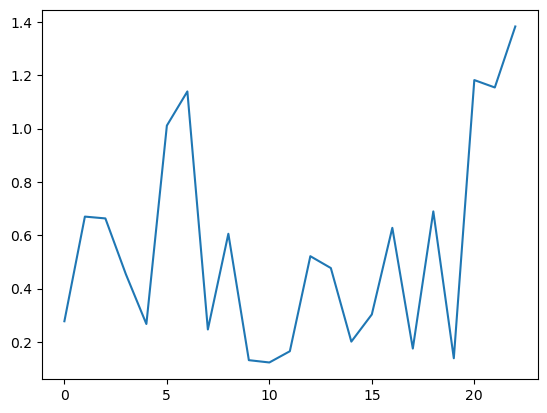

In [25]:
plt.plot(signal_sample)